In [1]:
import os
os.chdir(r'/content/drive/MyDrive/Work/PI_deepOnet_General/Anti_derivative')
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import os
import csv
#from models import Green_transformer

class SimpleCSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath

        # If the file doesn't exist, create one with headers.
        if not os.path.exists(filepath):
            with open(filepath, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['epoch', 'metric', 'value'])

    def log(self, epoch, metric, value):
        with open(self.filepath, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([epoch, metric, value])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#from utilities3 import *
Data = scipy.io.loadmat('Data.mat')
Fs = torch.tensor(Data['v'], dtype = torch.float32).to(device)
# COOR = torch.tensor(Data['coors'], dtype = torch.float32)
COOR = torch.linspace(0,1,Fs.size(1))[None,:,None].to(device)
coor  = COOR.repeat(len(Fs),1,1)
Y = torch.tensor(Data['u'], dtype = torch.float32).to(device)

Length = len(Fs)
Fs = Fs[:,:,None]
Y = Y[:,:,None]

torch.manual_seed(0)
np.random.seed(0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
batch_size = 16

x_data = Fs
c_data = coor
y_data = Y

x_train = x_data[0:int(0.8*Length),:,:]
c_train = c_data[0:int(0.8*Length),:,:]
y_train = y_data[0:int(0.8*Length),:,:]

x_test = x_data[int(0.8*Length):Length,:,:]
c_test = c_data[int(0.8*Length):Length,:,:]
y_test = y_data[int(0.8*Length):Length,:,:]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, c_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, c_test, y_test), batch_size=batch_size, shuffle=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [3]:
class MLP1(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                                           nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                                           nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                                           nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                                           nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class MLP2(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                                           nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                                           nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                                           nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                                           nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length):
        super(DeepOnet, self).__init__()

        self.encoder = nn.Linear(1, width_trunk) # input channel is 2: (a(x), x)
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLP = MLP1(width_trunk, width_branch, length)

    def forward(self, x, c):
        x = x.repeat(1,1,x.size(1)).permute(0,2,1)
        # print(x[0,:,:])
        # print(jj)
        x1 = self.MLP(x)

        c = self.encoder(c)
        c = F.tanh(c)
        c = self.w1(c)
        c = F.tanh(c)
        c = self.w2(c)
        c = F.tanh(c)
        c = self.w3(c)
        c = F.tanh(c)
        c = self.w4(c)
        y_PoU = torch.sum(c,2)

        c = c*x1
        y = torch.sum(c,2)

        return y,y_PoU


In [4]:
model = DeepOnet(width_trunk = 64, width_branch = 64, length = 512).to(device, dtype = torch.float32)
print(count_parameters(model))
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
num_epochs = 500

Rec = []

best_loss = np.inf
patience_counter=0
best_weights = None
patience = 300

for ep in range(num_epochs):
    model.train()
    t1 = default_timer()
    De_mse = 0
    train_l2 = 0
    Pe_mse = 0
    ne = 0
    nt = 0
    for x, c, y in train_loader:
        ne += 1
        x, c, y = x.cuda(), c.cuda(), y.cuda()

        optimizer.zero_grad()
        c.requires_grad = True
        out,out_PoU = model(x,c)

        De = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        Pe = F.mse_loss(out_PoU, torch.ones_like(out_PoU))

        mse =  De + Pe

        mse.backward() # use the l2 relative loss
        optimizer.step()

        De_mse += De.item()
        # Be_mse += Be.item()
        Pe_mse += Pe.item()

    scheduler.step()
    model.eval()
    test_mse = 0.0
    with torch.no_grad():
        for x, c, y in test_loader:
            nt += 1
            x, c, y = x.cuda(), c.cuda(), y.cuda()

            out,out_PoU = model(x,c)
            test_mse += F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    De_mse /= ne
    Pe_mse /= ne
    test_mse /= nt

    t2 = default_timer()
    print(ep, t2-t1, De_mse, Pe_mse, test_mse)
    recording = [t2-t1, De_mse, Pe_mse, test_mse]
    Rec.append(recording)
#%%

66240
0 2.857356235999987 0.09110654481127858 0.014104289877585871 0.03232726427912712
1 2.001516233000075 0.026677934113889933 8.086329296475014e-05 0.01625045869499445
2 1.9881830360000095 0.014677768550813198 3.165487082696927e-05 0.01317456515133381
3 1.991100748000008 0.011945959826931358 2.1029675585396035e-05 0.008980901293456554
4 1.9809699869999804 0.010547683597542346 0.00019146408524375148 0.007998828202486038
5 1.9566959829999178 0.007214700583834201 0.0001521795083408506 0.006452319737523794
6 2.0275162360001104 0.0069954161117784675 0.0001360167128282228 0.005417159426957369
7 1.9828729000000749 0.008065600954927504 0.0002829918291145077 0.010680819395929575
8 1.9837361130000772 0.005622408393770456 7.781244621719452e-05 0.004775303527712822
9 1.956163867999976 0.005041952388826758 9.463734525297696e-05 0.005263070296496153
10 1.939414010000064 0.005646755154244601 0.00018353880417453183 0.0042377033997327085
11 1.9396964900001876 0.006330025455914438 0.000331464983562000

In [5]:
mdic1 = {'Rec':Rec}
scipy.io.savemat(r'Dp_PoU_training.mat',mdic1)

torch.save(model, 'Dp_PoU_model')

0.002408081000794482


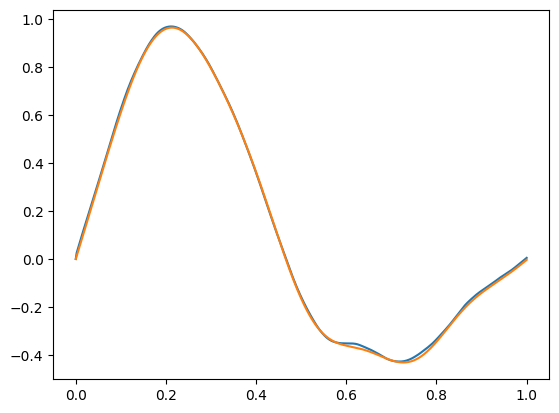

In [ ]:
num = 10 #10;20;60
x = x_test[num,:,:][None,:,:].cuda()
c = c_test[num,:,:][None,:,:].cuda()
y = y_test[num,:,:][None,:,:].cpu()
# x = torch.ones(1,n,1).cuda() + 10
t1 = default_timer()
out = model(x,c).squeeze().cpu()
t2 = default_timer()
print((t2-t1))

plt.figure()
plt.plot(c.squeeze().cpu().detach().numpy(),y.squeeze().detach().numpy())
plt.plot(c.squeeze().cpu().detach().numpy(),out.detach().numpy())
plt.show()


In [ ]:
xr = x.squeeze().cpu().detach().numpy()
cr = c.squeeze().cpu().detach().numpy()
yp = out.squeeze().cpu().detach().numpy()
yt = y.squeeze().cpu().detach().numpy()

mdic1 = {'x':xr,'c':cr,'yp':yp,'yt':yt}

# scipy.io.savemat(r'Recoding/Data1/Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/EDP_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_EDP_relu.mat',mdic1)
scipy.io.savemat(r'Recoding/Data1/Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/EDP_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data1/pi_EDP_tanh.mat',mdic1)

In [ ]:
xr = x.squeeze().cpu().detach().numpy()
cr = c.squeeze().cpu().detach().numpy()
yp = out.squeeze().cpu().detach().numpy()
yt = y.squeeze().cpu().detach().numpy()

mdic1 = {'x':xr,'c':cr,'yp':yp,'yt':yt}

# scipy.io.savemat(r'Recoding/Data2/Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/EDP_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_EDP_relu.mat',mdic1)
scipy.io.savemat(r'Recoding/Data2/Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/EDP_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data2/pi_EDP_tanh.mat',mdic1)

In [ ]:
xr = x.squeeze().cpu().detach().numpy()
cr = c.squeeze().cpu().detach().numpy()
yp = out.squeeze().cpu().detach().numpy()
yt = y.squeeze().cpu().detach().numpy()

mdic1 = {'x':xr,'c':cr,'yp':yp,'yt':yt}

# scipy.io.savemat(r'Recoding/Data3/Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_Dp_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/EDP_relu.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_EDP_relu.mat',mdic1)
scipy.io.savemat(r'Recoding/Data3/Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_Dp_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/EDP_tanh.mat',mdic1)
# scipy.io.savemat(r'Recoding/Data3/pi_EDP_tanh.mat',mdic1)

ValueError: ignored

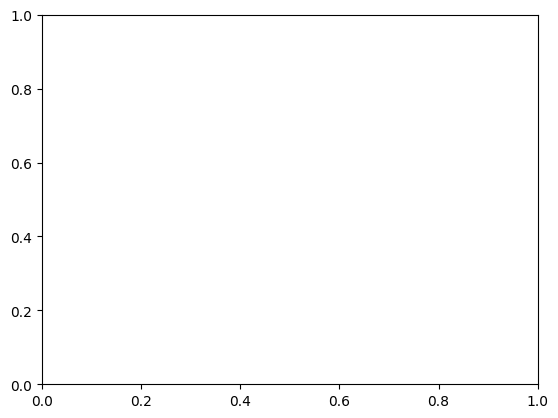

In [ ]:
n = 128

num = 2
x = x_test[num,:,:][None,:,:].cuda()
c = c_test[num,:,:][None,:,:].cuda()
y = y_test[num,:,:][None,:,:].cpu()
c.requires_grad = True
out = model(x,c)
dydc = autograd.grad(out,c,torch.ones_like(out).to(device),retain_graph=True,create_graph=True)[0]
# dydc2 = autograd.grad(dydx,c,torch.ones_like(dydx).to(device),retain_graph=True,create_graph=True)[0]

xl = torch.linspace(0,1,n)

out = out.squeeze()
dydc = dydc.squeeze()
dout = (out[1:] - out[:-1])*(n-1)


plt.figure()
plt.plot(xl.squeeze().cpu().detach().numpy(),out.squeeze().cpu().detach().numpy())
plt.show()
plt.figure()
plt.plot(xl.squeeze().cpu().detach().numpy(),dydc.squeeze().cpu().detach().numpy())
# plt.plot(xl.squeeze().cpu().detach().numpy(),x.squeeze().cpu().detach().numpy())
plt.plot(xl[1:].squeeze().cpu().detach().numpy(),dout.squeeze().cpu().detach().numpy())
# plt.plot(xl.squeeze().cpu().detach().numpy(),dydx2.squeeze().cpu().detach().numpy())
plt.show()